In [3]:
import pandas as pd
import pandasql
import numpy as np
from pandasql import sqldf
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
pysqldf = lambda q: sqldf(q, globals())

In [4]:
bom_df = pd.read_csv("data/bom.movie_gross.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")
rt_movies = pd.read_csv("data/rt.movie_info.tsv", delimiter="\t")
rt_reviews = pd.read_csv("data/rt.reviews.tsv", delimiter="\t")
tmdb_df = pd.read_csv("data/tmdb.movies.csv")
tn_df = pd.read_csv("data/tn.movie_budgets.csv")

conn = sqlite3.connect("data/im.db")
imdb_tables = pd.read_sql("""
SELECT name FROM sqlite_master
    WHERE type='table'
""", conn)

movie_basics = pd.read_sql(""" SELECT * FROM movie_basics """, conn)
directors = pd.read_sql(""" SELECT * FROM directors """, conn)
known_for = pd.read_sql(""" SELECT * FROM known_for """, conn)
movie_akas = pd.read_sql(""" SELECT * FROM movie_akas """, conn)
movie_ratings = pd.read_sql(""" SELECT * FROM movie_ratings """, conn)
persons = pd.read_sql(""" SELECT * FROM persons """, conn)
principals = pd.read_sql(""" SELECT * FROM principals """, conn)
writers = pd.read_sql(""" SELECT * FROM writers """, conn)

# Combining movie, genre, budget, gross, and ROI data

In order to perform our analyses, we will need to combine data from the IM.DB database (which contains genre data), box office mojo (which contains studio data), and The Numbers (which contains budget and gross data). Our dataset will be smaller than any one of the original datasets, but this is the only way to conduct our analyses.

In [5]:
def money_to_int(x):
    x = x[1:]
    split = x.split(",")
    joined = "".join(split)
    integer = int(joined)
    return integer

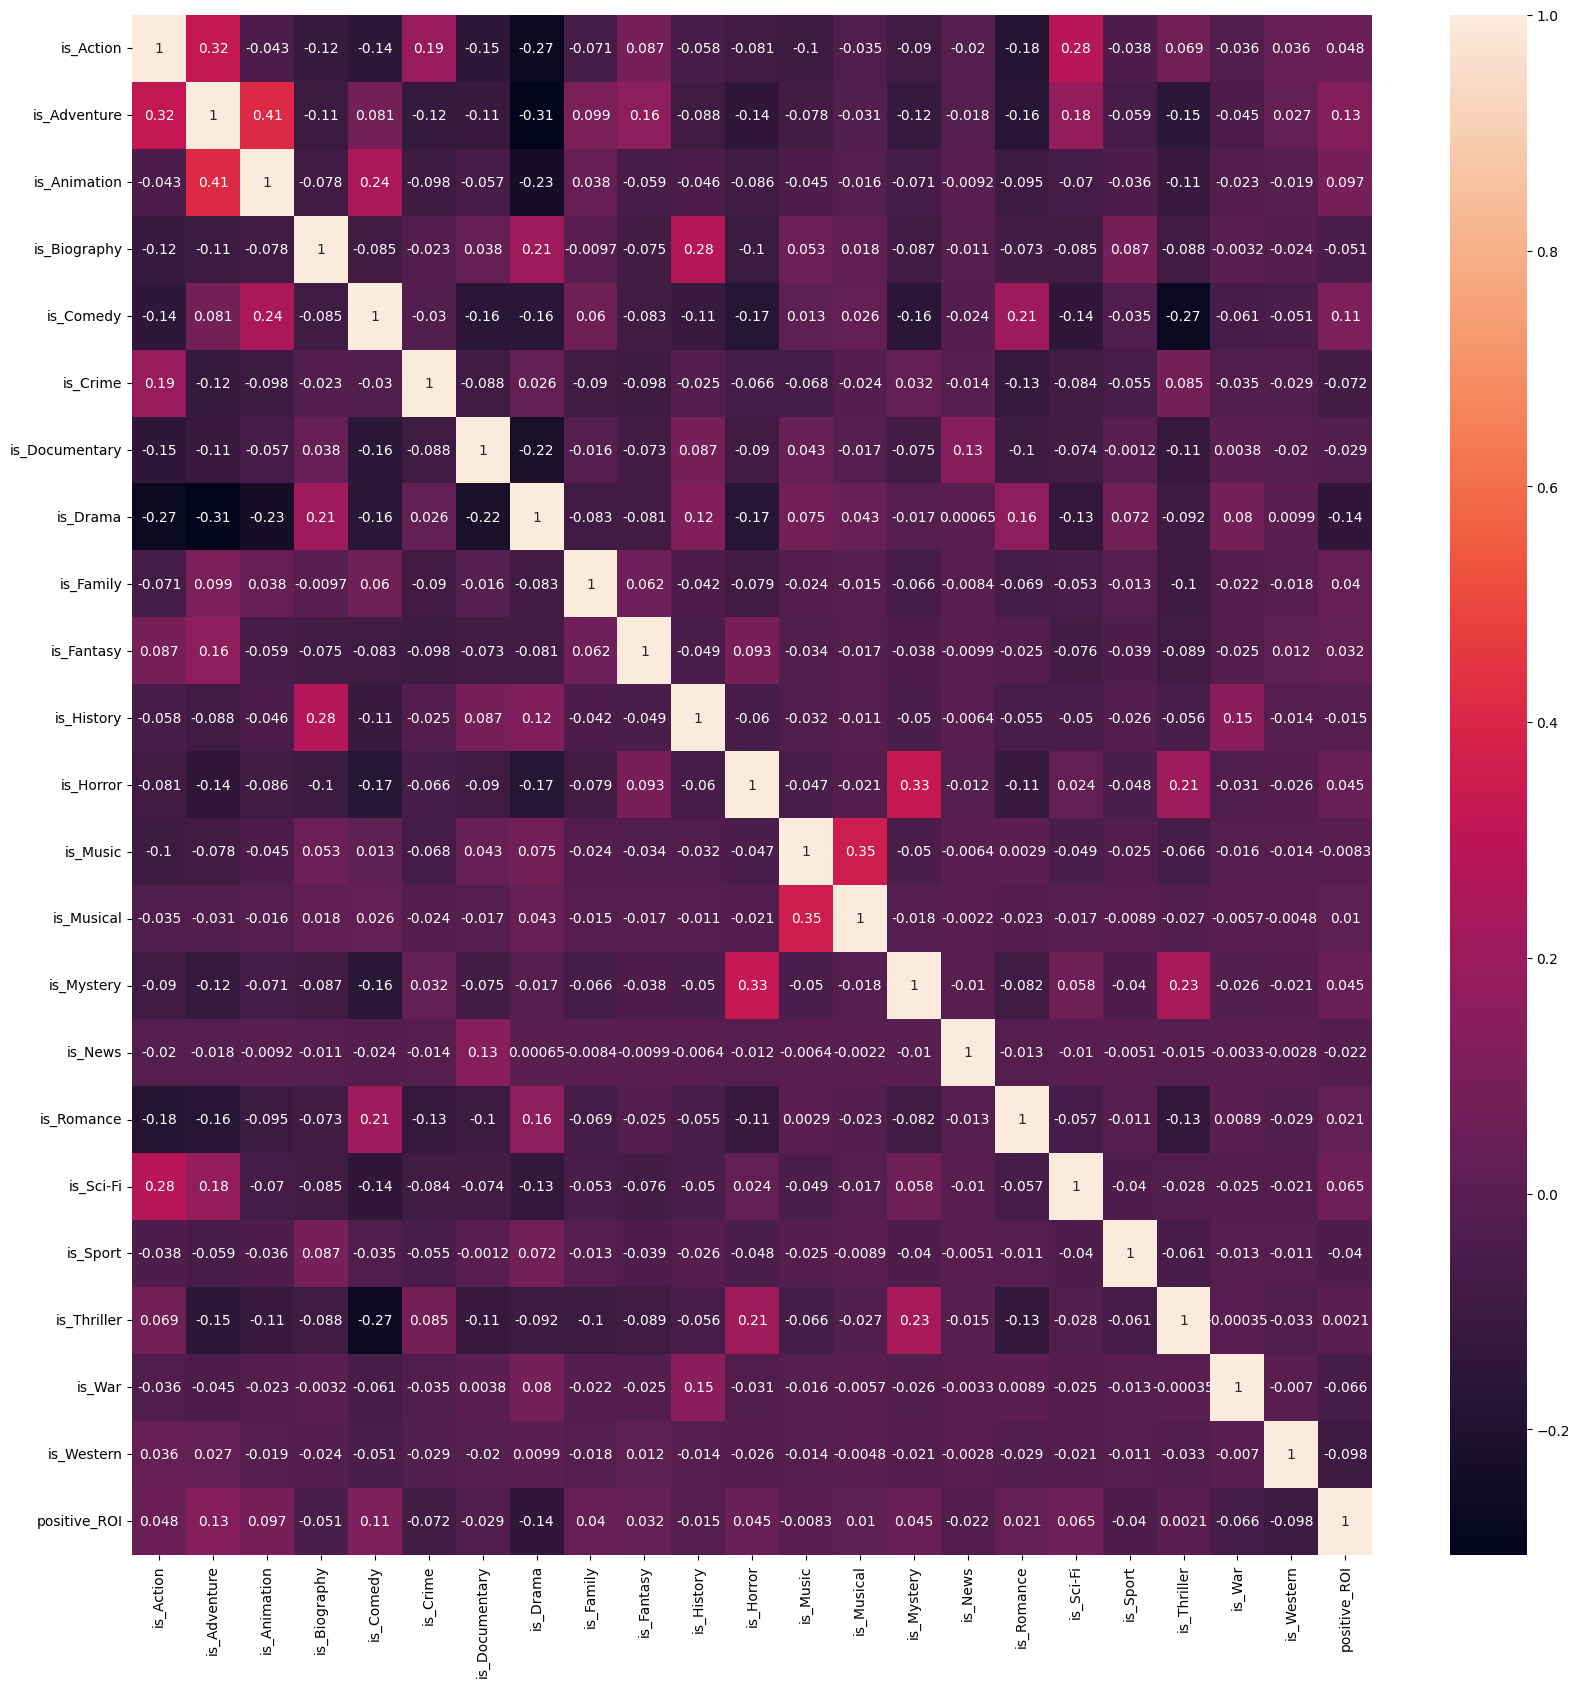

In [6]:
q = """
SELECT movie_basics.movie_id,
       bom_df.year,
       bom_df.studio,
       bom_df.title,
       movie_basics.runtime_minutes,
       movie_basics.genres,
       tn_df.domestic_gross,
       tn_df.worldwide_gross,
       tn_df.production_budget

FROM tn_df
JOIN bom_df
    ON title = movie
JOIN movie_basics
    ON title = primary_title
"""

df = pysqldf(q)

genres = (list(df['genres'].unique()))
genres.remove(None)
genres = ",".join(genres)
genres = genres.split(",")
genres = sorted(list(set(genres)))

# Changing budget and gross columns to integer types
df['production_budget'] = df['production_budget'].map(lambda x: money_to_int(x))
df['domestic_gross'] = df['domestic_gross'].map(lambda x: money_to_int(x))
df['worldwide_gross'] = df['worldwide_gross'].map(lambda x: money_to_int(x))

# Creating new columns
df['foreign_gross'] = df['worldwide_gross'] - df['domestic_gross']
df['ROI'] = round((df['worldwide_gross'] / df['production_budget'])*100, 2)
df['positive_ROI'] = df['ROI'].map(lambda x: True if x>100 else False)

# Elminating null values
df['genres'] = df['genres'].map(lambda x: 'None' if not x else x)

for i in genres:
    df["is_"+i] = df['genres'].map(lambda x: True if i in x else False)

q = """
SELECT * FROM df
WHERE movie_id NOT IN (SELECT movie_id
                       FROM df
                       GROUP BY movie_id
                       HAVING COUNT(*)>=2)
"""

df = pysqldf(q)

# for i in list(range(12, 36)):
#     if df.iloc[:, i].value_counts()[False] == 1546:
#         print(df.iloc[:, i].value_counts())

corr = df.iloc[:, 12:12+(len(genres))].copy()
corr['positive_ROI'] = df['positive_ROI']

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr.corr(), ax=ax, annot=True);

In [7]:
corr.corr()

,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,...,is_Musical,is_Mystery,is_News,is_Romance,is_Sci-Fi,is_Sport,is_Thriller,is_War,is_Western,positive_ROI
is_Action,1.000000,0.322865,-0.043291,-0.121051,-0.144084,0.190294,-0.145410,-0.270208,-0.071171,0.087144,...,-0.035385,-0.089681,-0.020403,-0.179346,0.282957,-0.038069,0.069237,-0.035692,0.035893,0.048072
is_Adventure,0.322865,1.000000,0.408092,-0.105025,0.081211,-0.121391,-0.111714,-0.306420,0.098997,0.160036,...,-0.030691,-0.119247,-0.017697,-0.163554,0.175274,-0.058682,-0.152140,-0.045279,0.026792,0.130403
is_Animation,-0.043291,0.408092,1.000000,-0.078382,0.242246,-0.098078,-0.057123,-0.233627,0.038318,-0.059110,...,-0.015882,-0.071449,-0.009157,-0.094956,-0.070421,-0.036396,-0.109072,-0.023430,-0.019470,0.096538
is_Biography,-0.121051,-0.105025,-0.078382,1.000000,-0.084799,-0.022846,0.037544,0.212520,-0.009694,-0.075406,...,0.017746,-0.086507,-0.011087,-0.072859,-0.085262,0.087136,-0.087621,-0.003192,-0.023573,-0.051206
is_Comedy,-0.144084,0.081211,0.242246,-0.084799,1.000000,-0.030073,-0.160498,-0.160655,0.060351,-0.082835,...,0.026285,-0.159479,-0.023896,0.206435,-0.140078,-0.034892,-0.272991,-0.061141,-0.050806,0.110389
is_Crime,0.190294,-0.121391,-0.098078,-0.022846,-0.030073,1.000000,-0.087528,0.026259,-0.090047,-0.098078,...,-0.024061,0.032445,-0.013873,-0.126207,-0.084195,-0.055140,0.084901,-0.035497,-0.029497,-0.072277
is_Documentary,-0.145410,-0.111714,-0.057123,0.037544,-0.160498,-0.087528,1.000000,-0.215676,-0.015573,-0.073218,...,-0.016676,-0.075024,0.134712,-0.099707,-0.073944,-0.001209,-0.114530,0.003803,-0.020444,-0.029034
is_Drama,-0.270208,-0.306420,-0.233627,0.212520,-0.160655,0.026259,-0.215676,1.000000,-0.083384,-0.081325,...,0.042750,-0.017283,0.000652,0.158829,-0.130878,0.071818,-0.092277,0.079601,0.009890,-0.141185
is_Family,-0.071171,0.098997,0.038318,-0.009694,0.060351,-0.090047,-0.015573,-0.083384,1.000000,0.061989,...,-0.014581,-0.065599,-0.008408,-0.069352,-0.053296,-0.012585,-0.100141,-0.021512,-0.017876,0.040163
is_Fantasy,0.087144,0.160036,-0.059110,-0.075406,-0.082835,-0.098078,-0.073218,-0.081325,0.061989,1.000000,...,-0.017106,-0.037961,-0.009863,-0.024812,-0.075849,-0.039202,-0.089452,-0.025237,0.012384,0.032465


# Conclusion

There aren't any striking correlations between genre and ROI. In fact, the most powerful correlation are ones between genres themselves. For example, adventure has a moderate correlation with action and adventure has a similar correlation with animation.

Adventure, animation and comedy have the strongest correlations with whether or not a movie is profitable. Horror, mystery and thriller have the strongest correlations with ROI.

What if certain combinations of genres have greater correlations with ROI? To find out, I have selected some of the most frequently seen genre combinations in our dataset, created new columns in the dataframe, and created another heatmap.

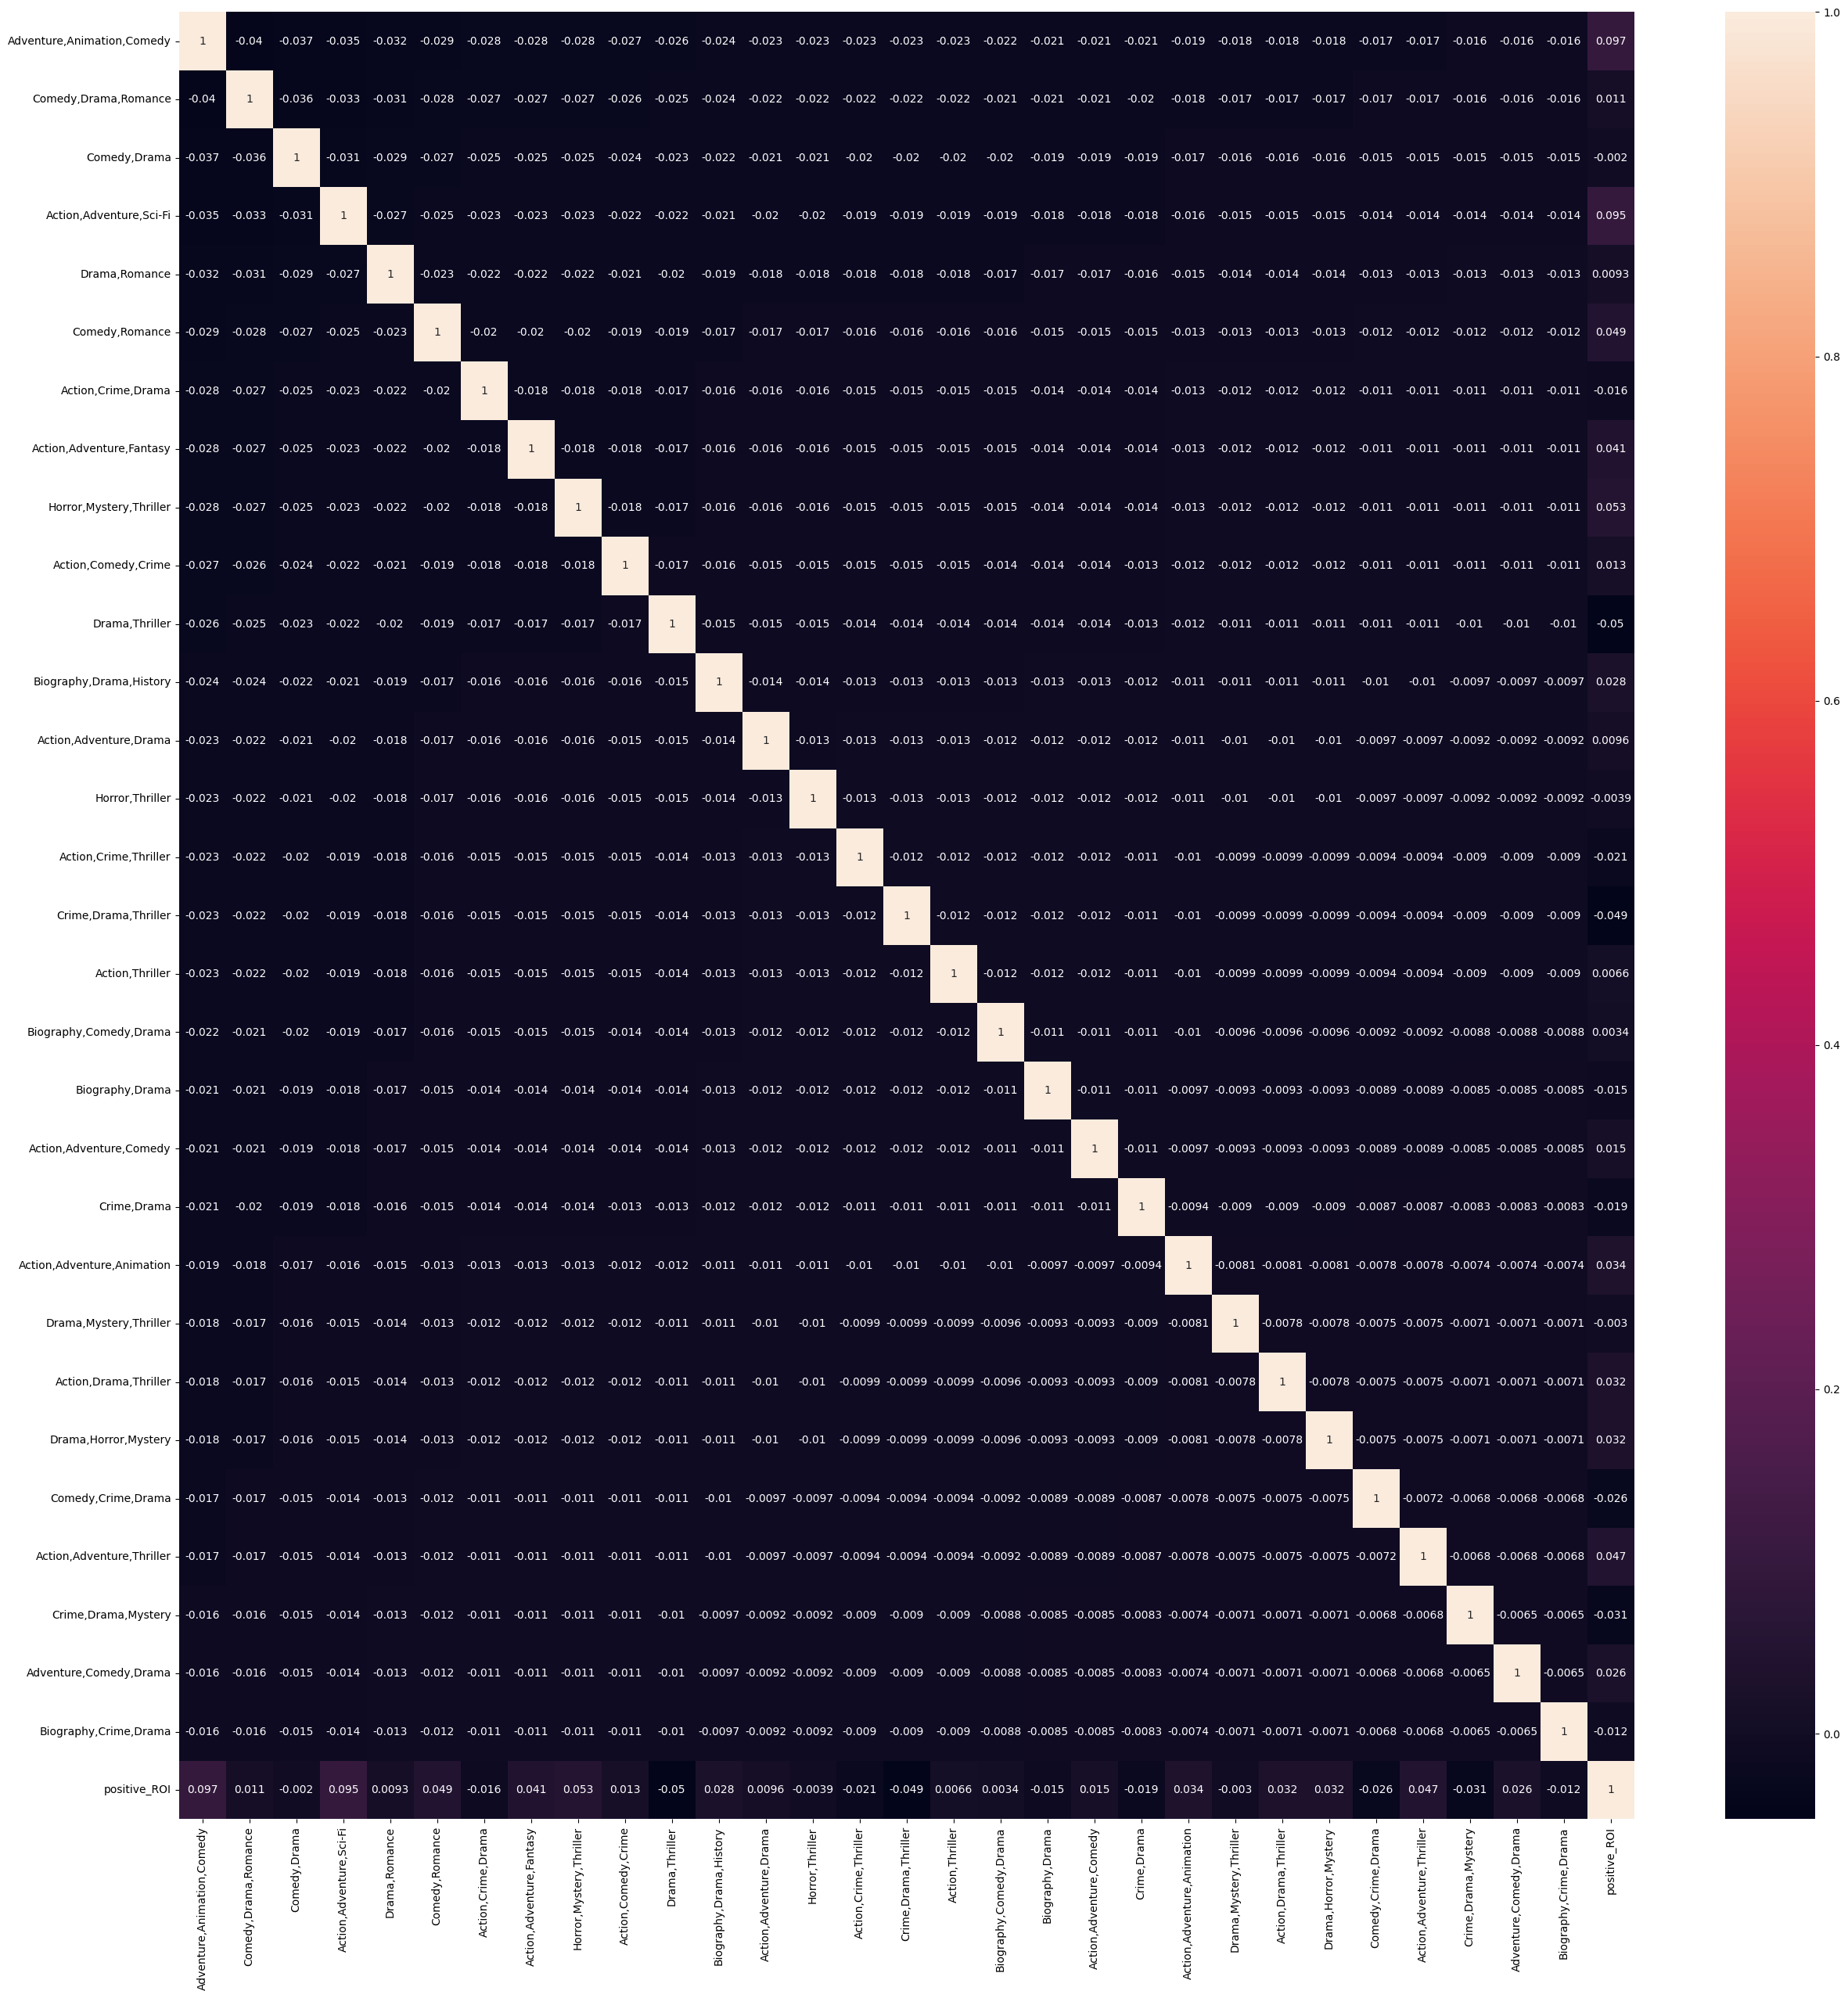

In [8]:
combinations = {key: value for key, value in dict(df.genres.value_counts()).items() if ((value >= 10) & (len(key.split(","))>1))}

for i in combinations.keys():
    df[i] = df.genres.map(lambda x: True if x == i else False)

corr = df.iloc[:, 12+(len(genres)):].copy()
corr['positive_ROI'] = df['positive_ROI']

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr.corr(), ax=ax, annot=True);

# ROI with or without the presence of a genre

For example, action movies are 53% less profitable than non-action movies.

In [22]:
with_without_average

[[442.6903234152652, 483.42495726495724, 315.9362765957447],
 [442.6903234152652, 469.77401606425695, 330.6664119601329],
 [442.6903234152652, 446.06019972451793, 390.63648936170216],
 [442.6903234152652, 451.4082648725212, 350.8266417910448],
 [442.6903234152652, 470.3038210624417, 380.049133192389],
 [442.6903234152652, 469.7145022288261, 260.81759999999997],
 [442.6903234152652, 448.9025433125433, 355.6589320388349],
 [442.6903234152652, 499.1872554002541, 384.1091831357049],
 [442.6903234152652, 452.967346521146, 254.363875],
 [442.6903234152652, 447.8937899860918, 373.40712962962965],
 [442.6903234152652, 447.5742323097463, 290.2716666666667],
 [442.6903234152652, 356.5978329733621, 1204.362101910828],
 [442.6903234152652, 443.76323549032696, 408.47127659574465],
 [442.6903234152652, 442.9423181818182, 378.0116666666667],
 [442.6903234152652, 383.2578018143754, 1196.378849557522],
 [442.6903234152652, 443.1363730569948, 98.34],
 [442.6903234152652, 440.52311717022843, 458.25063492

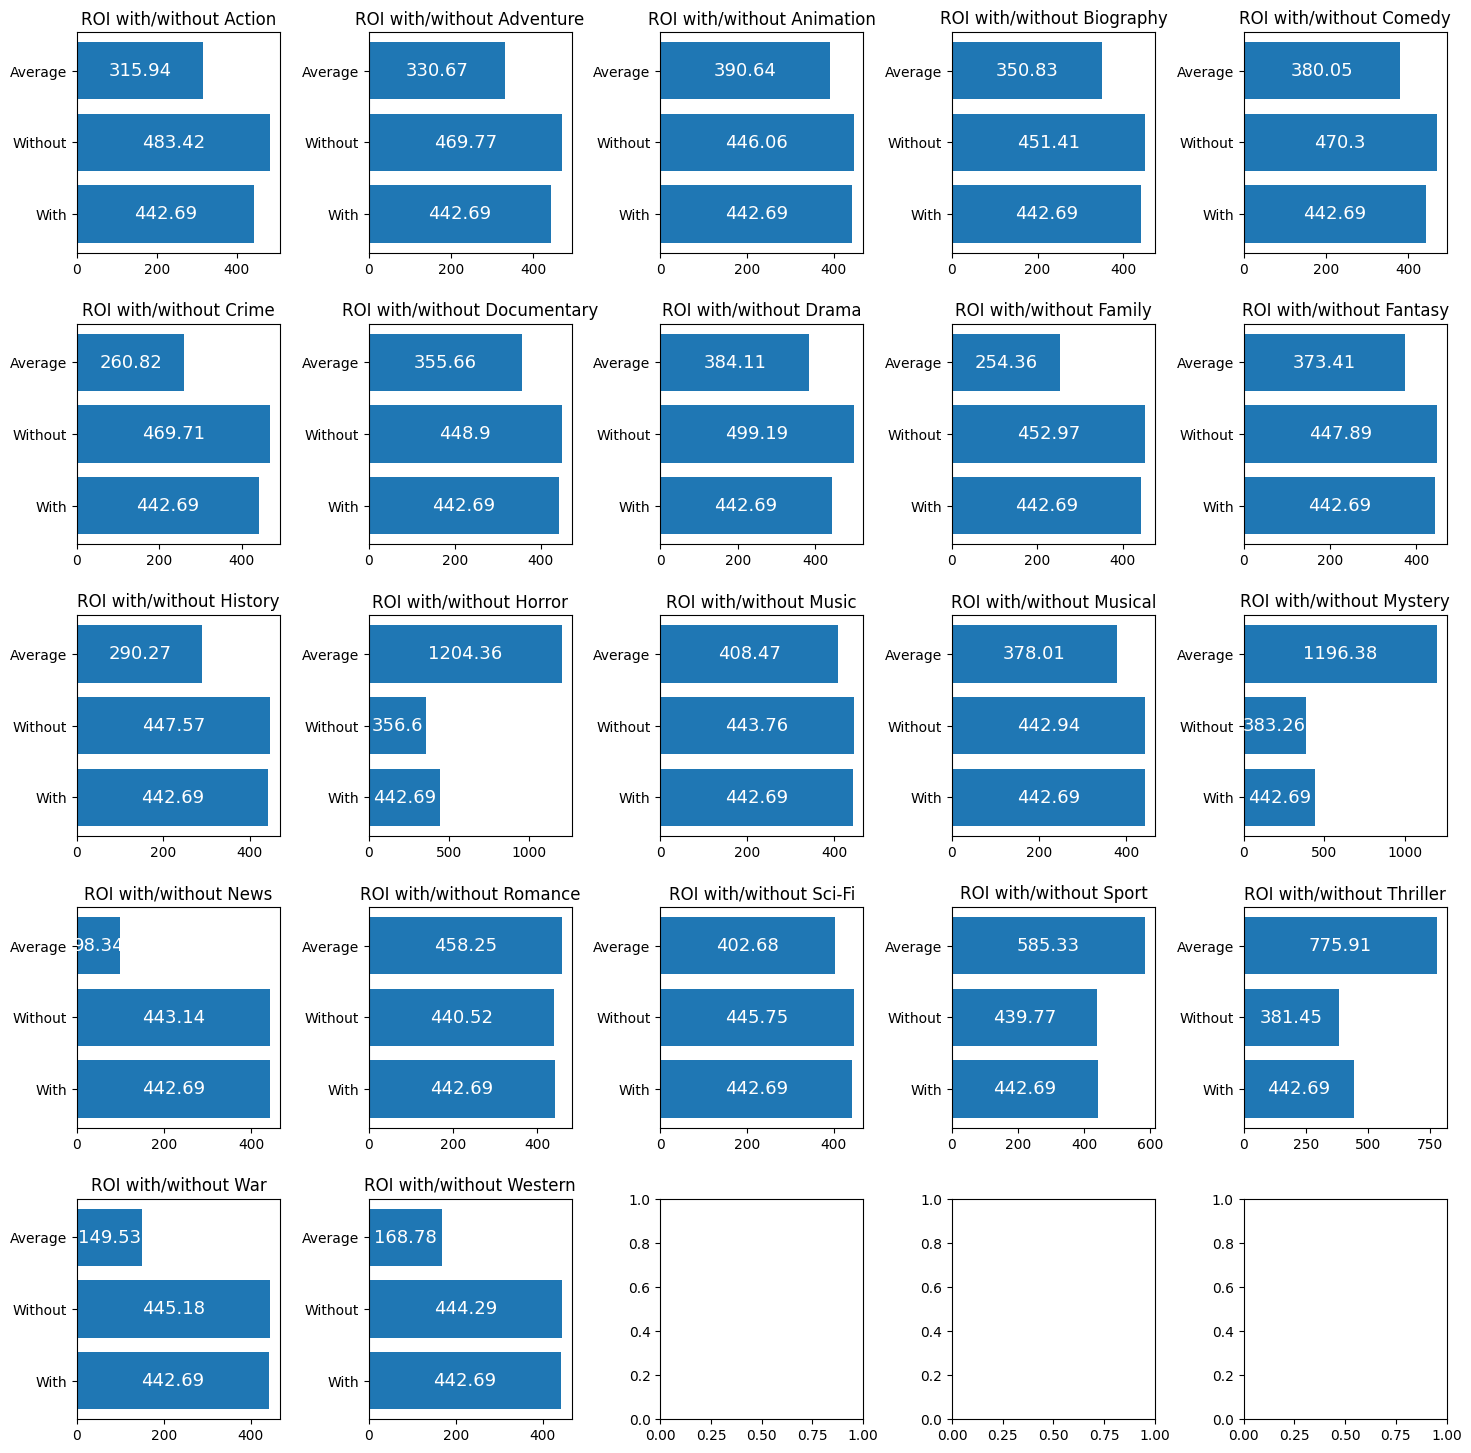

In [29]:
with_without_average = []
average = df['ROI'].mean()

for i in range(len(genres)):
    on = df[df['is_' + genres[i]]==1]['ROI'].mean()
    off = df[df['is_' + genres[i]]==0]['ROI'].mean()
    with_without_average.append([average, off, on])
    

rows = 5
cols = 5

fig, ax = plt.subplots(rows,cols, figsize=(15,15))
fig.tight_layout(pad=3)
for i in range(rows*cols):
    
    try:
        row = i//rows
        col = i%rows

        x = ['With', 'Without', 'Average']
        y = with_without_average[i]
        ylabels=[round(i,2) for i in y]

        title = "ROI with/without {}".format(genres[i])
        ax[row,col].set_title(title)

        barplot = ax[row,col].barh(x,y)
        ax[row,col].bar_label(barplot, labels=ylabels, label_type='center', color='white', fontsize='13');
        
    except:
        break



# Hitrate with or without the presence of a genre

For example, in the first graph, this means that action movies are 7% more likely to be profitable than non-action movies or your average movie. Likewise, adventure movies are 19% more likely to be profitable than non-adventure movies but only 16% more likely to be profitable than your average movie.

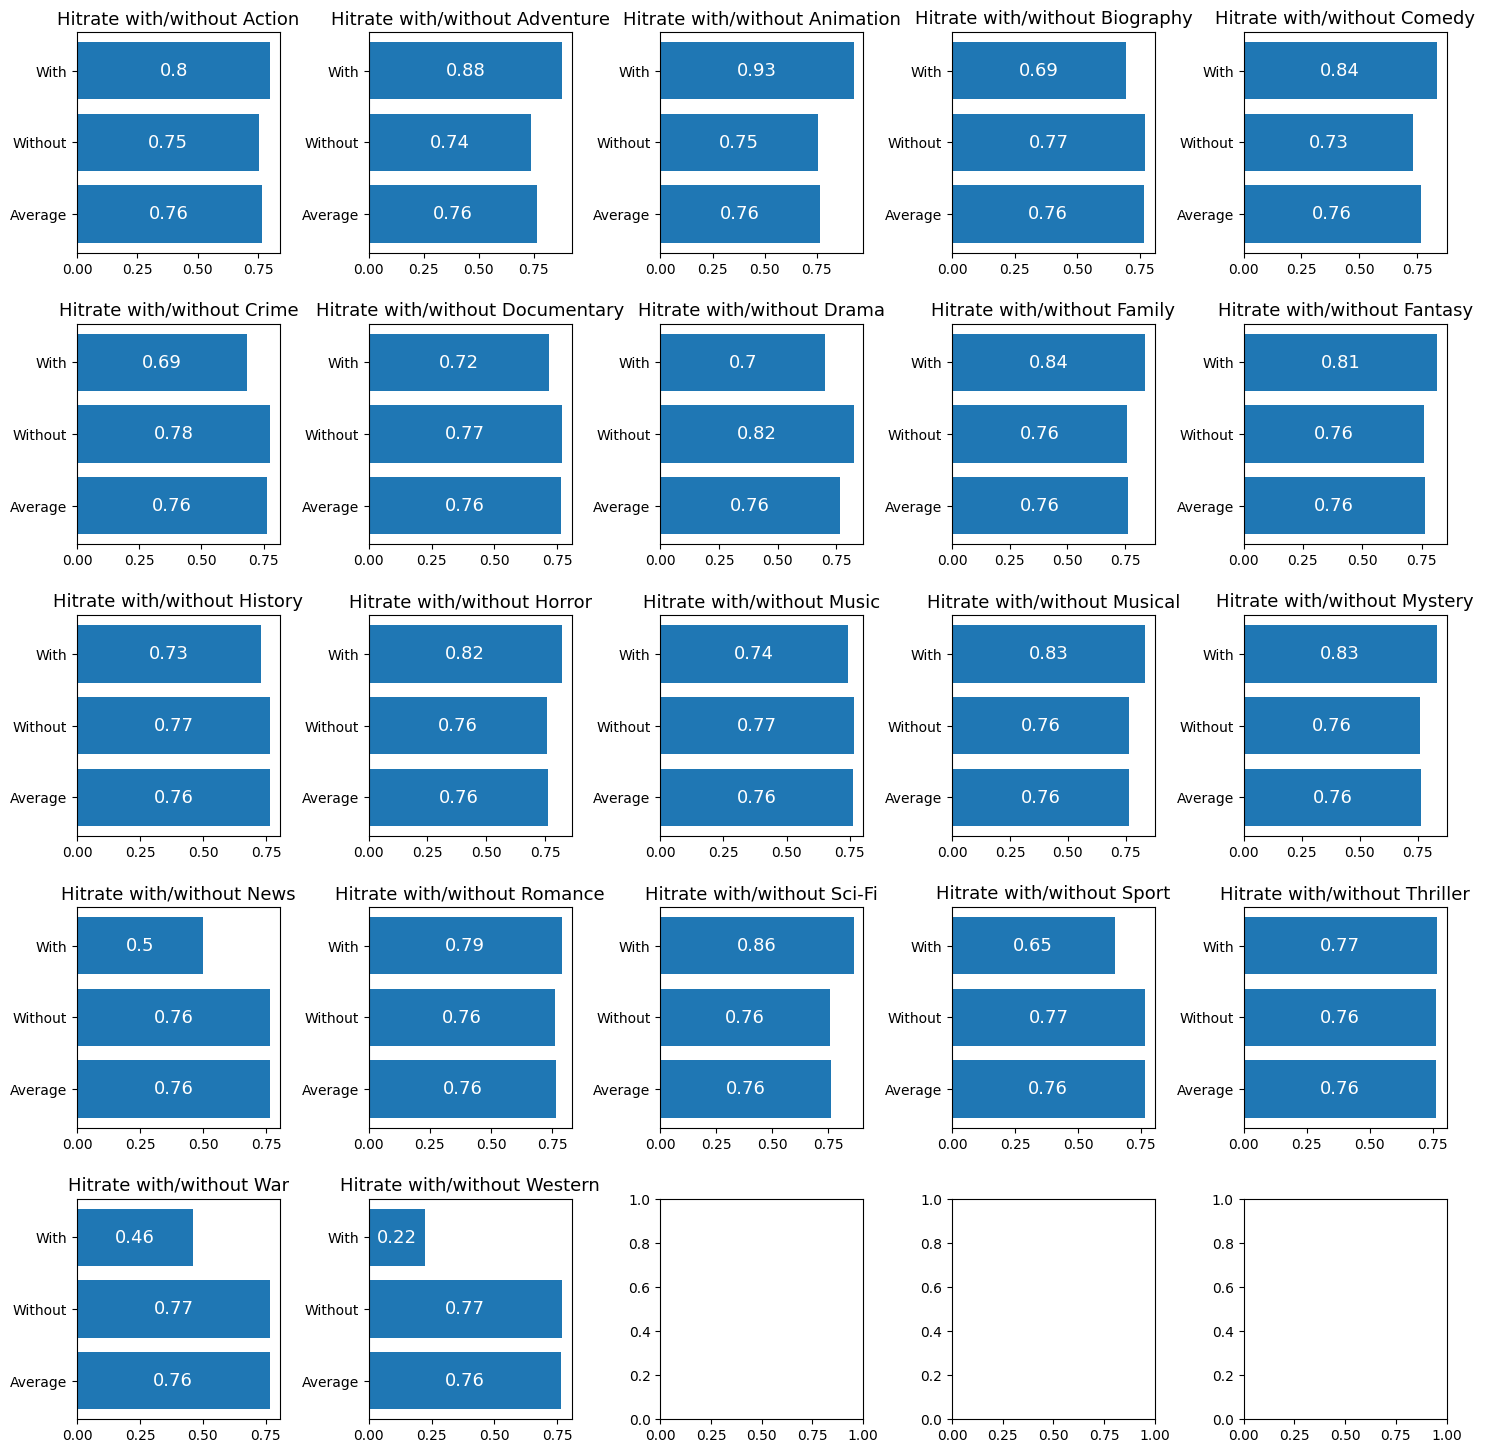

In [10]:
with_without_average=[]

for i in range(len(genres)):
    
    genre = genres[i]
    colname = "is_" + genre
    
    on = len(df[(df[colname]==1) & (df.positive_ROI==1)])/\
         len(df[(df[colname]==1)])
    
    off = len(df[(df[colname]==0) & (df.positive_ROI==1)])/\
          len(df[(df[colname]==0)])
    
    average = len(df[df.positive_ROI == 1])/\
              len(df)
    
    with_without_average.append([average, off, on])
    
    
    
rows = 5
cols = 5

fig, ax = plt.subplots(rows,cols, figsize=(15,15))
fig.tight_layout(pad=3)

for i in range(rows*cols):
    
    try:
        row = i//rows
        col = i%rows

        x = ['Average', 'Without', 'With']
        y = with_without_average[i]
        ylabels=[round(i,2) for i in y]

        title = "Hitrate with/without {}".format(genres[i])
        ax[row,col].set_title(title, fontsize='13')

        barplot = ax[row,col].barh(x,y)
        ax[row,col].bar_label(barplot, labels=ylabels, label_type='center', color='white', fontsize='13');
        
    except:
        break

In [11]:
df

,movie_id,year,studio,title,runtime_minutes,genres,domestic_gross,worldwide_gross,production_budget,foreign_gross,...,"Crime,Drama","Action,Adventure,Animation","Drama,Mystery,Thriller","Action,Drama,Thriller","Drama,Horror,Mystery","Comedy,Crime,Drama","Action,Adventure,Thriller","Crime,Drama,Mystery","Adventure,Comedy,Drama","Biography,Crime,Drama"
0,tt1298650,2011,BV,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",241063875,1045663875,410600000,804600000,...,False,False,False,False,False,False,False,False,False,False
1,tt2395427,2015,BV,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",459005868,1403013963,330600000,944008095,...,False,False,False,False,False,False,False,False,False,False
2,tt4154756,2018,BV,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",678815482,2048134200,300000000,1369318718,...,False,False,False,False,False,False,False,False,False,False
3,tt0974015,2017,WB,Justice League,120.0,"Action,Adventure,Fantasy",229024295,655945209,300000000,426920914,...,False,False,False,False,False,False,False,False,False,False
4,tt2379713,2015,Sony,Spectre,148.0,"Action,Adventure,Thriller",200074175,879620923,300000000,679546748,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,tt1748207,2012,FoxS,Sound of My Voice,85.0,"Drama,Mystery,Sci-Fi",408015,429448,135000,21433,...,False,False,False,False,False,False,False,False,False,False
1542,tt1742336,2012,IFC,Your Sister's Sister,90.0,"Comedy,Drama",1597486,3090593,120000,1493107,...,False,False,False,False,False,False,False,False,False,False
1543,tt2309260,2015,WB (NL),The Gallows,81.0,"Horror,Mystery,Thriller",22764410,41656474,100000,18892064,...,False,False,False,False,False,False,False,False,False,False
1544,tt6265828,2017,A24,A Ghost Story,92.0,"Drama,Fantasy,Romance",1594798,2769782,100000,1174984,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# rows = 5
# cols = 5

# fig, ax = plt.subplots(rows,cols, figsize=(15,15))
# fig.tight_layout(pad=10) # Spacing out individual axes

# for i in range(rows*cols):
    
#     # There are 25 axes but the number of genres is fewer;
#     # The try-except will try to populate cells until there are no more genres left,
#     # at which point the except clause will catch an error and end the loop
#     try:
        
#         # These two variables make the coordinates for the axis
#         row = i//rows
#         col = i%rows

#         x = ['Average', 'Without', 'With']
#         y = with_without_average[i][0]
#         ylabels=[round(i,2) for i in y]
        
#         stds = with_without_average[i][1]
#         roots = with_without_average[i][2]

#         title = "Hitrate with/without {}".format(genres[i])
#         ax[row,col].set_title(title, fontsize='13')
        

#         ax[row,col].errorbar(x, y, yerr=errorbars, fmt='ro')
        
#     except:
#         break